1 Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns
import imageio
import cv2
from matplotlib.patches import Patch

2 Loading Global Variables

In [2]:
warnings.filterwarnings("ignore")
sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 1

id_map = {
    0: (0, 0, 0), # unlabelled
    1: ( 81,  0, 81), #ground
    2: (128, 64,127), #road
    3: (244, 35,232), #sidewalk
    4: (70, 70, 70), #building
    5: (102,102,156), #wall
    6: (190,153,153), #fence
    7: (250,170, 30), #traffic light
    8: (107,142, 35), #vegetation
    9: (152,251,152), #terrain
    10: ( 70,130,180), #sky
    11: (220, 20, 60), #person
    12: (  0,  0,142), #car
    13: (  0,  0,230), #motorcycle
    14: (119, 11, 32), #bicycle
}

class_names = {
    0: "Unlabelled",
    1: "Ground",
    2: "Road",
    3: "Sidewalk",
    4: "Building",
    5: "Wall",
    6: "Fence",
    7: "Traffic Light",
    8: "Vegetation",
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Car",
    13: "Motorcycle",
    14: "Bicycle",
}

num_classes = len(id_map.keys())

3 Preprocessing Data

In [3]:
def preprocess(path,pathmask):
    img = Image.open(path)
    imgmask=Image.open(pathmask)
    img1 = img.resize((512, 512)).convert("RGB")
    img2 = imgmask.resize((512, 512)).convert("RGB")
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype=np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key is None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    return img1, mask

In [4]:
def videoprocess(path):
    img = Image.open(path)
    img1 = img.resize((512, 512)).convert("RGB")
    img1 = np.array(img1) / 255.
    return img1

In [5]:
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}",f"D:/cityscapes2/trainmask/{file[:-15]}"+"gtFine_color.png")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}",f"D:/cityscapes2/valmask/{file[:-15]}"+"gtFine_color.png")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

In [6]:
def video_prepare_tensor_dataset(path):
    X = []
    for file in tqdm(os.listdir(path)):
        img = videoprocess(f"{path}/{file}")
        X.append(img)

    return X

4 Conversion Functions

In [7]:
def label_to_color(mask, id_map):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for id_val, color in id_map.items():
        color_mask[mask == id_val] = color
    return color_mask

In [8]:
def overlay_mask_on_image(image, mask, alpha=0.4):
    # Ensure the mask is in the same range as the image
    image = image
    mask = mask / 255.0  # Normalize mask to [0, 1]
    # Blend images using addWeighted
    overlay_img = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)
    return (overlay_img * 255).astype(np.uint8)

5 Plotting Function

In [9]:
def mask_plot(X,num_elements,model):
    plt.style.use("default")
    for i in range(num_elements):
        img = X[i]
        img = np.reshape(img, (1, 512, 512, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (512, 512))
        
        #converting predicted values to RGB
        y_pred_rgb = label_to_color(y_pred, id_map)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        
        img = np.reshape(img, (512, 512, 3))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(y_pred_rgb)
        axes[1].set_title("Predicted Mask")
        axes[1].axis("off")
        
        # Overlay the mask on the original image with alpha transparency
        overlay_img = img.copy()
        axes[2].imshow(img)
        axes[2].imshow(y_pred_rgb, alpha=0.4)  # Adjust alpha to control transparency
        axes[2].set_title("Overlay Mask on Image")
        axes[2].axis("off")

        # Create custom legend
        legend_elements = [Patch(facecolor=np.array(color)/255, edgecolor='w', label=class_names[label]) for label, color in id_map.items()]
        axes[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

        plt.show()

6 UNET Model

In [10]:
def unet_model(num_classes):
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    
    # First Downsample
    conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(conv1)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    dropout1 = tf.keras.layers.Dropout(0.2)(pool1)
    
    # Second Downsample
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(dropout1)
    batch_norm2 = tf.keras.layers.BatchNormalization()(conv3)
    conv4 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)
    dropout2 = tf.keras.layers.Dropout(0.2)(pool2)
    
    # Third Downsample
    conv5 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(dropout2)
    batch_norm3 = tf.keras.layers.BatchNormalization()(conv5)
    conv6 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv6)
    dropout3 = tf.keras.layers.Dropout(0.2)(pool3)
    
    # Fourth Downsample
    conv7 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(dropout3)
    batch_norm4 = tf.keras.layers.BatchNormalization()(conv7)
    conv8 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv8)
    dropout4 = tf.keras.layers.Dropout(0.2)(pool4)
    
    # Fifth Downsample
    conv9 = tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(dropout4)
    batch_norm5 = tf.keras.layers.BatchNormalization()(conv9)
    conv10 = tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm5)
    
    # First Upsample
    upsample1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv10)
    dropout5 = tf.keras.layers.Dropout(0.2)(upsample1)
    concat1 = tf.keras.layers.Concatenate()([dropout5, conv8])
    conv11 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(concat1)
    batch_norm6 = tf.keras.layers.BatchNormalization()(conv11)
    conv12 = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm6)
    
    # Second Upsample
    upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv12)
    dropout6 = tf.keras.layers.Dropout(0.2)(upsample2)
    concat2 = tf.keras.layers.Concatenate()([dropout6, conv6])
    conv13 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(concat2)
    batch_norm7 = tf.keras.layers.BatchNormalization()(conv13)
    conv14 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm7)
    
    # Third Upsample
    upsample3 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv14)
    dropout7 = tf.keras.layers.Dropout(0.2)(upsample3)
    concat3 = tf.keras.layers.Concatenate()([dropout7, conv4])
    conv15 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(concat3)
    batch_norm8 = tf.keras.layers.BatchNormalization()(conv15)
    conv16 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm8)
    
    # Fourth Upsample
    upsample4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv16)
    dropout8 = tf.keras.layers.Dropout(0.2)(upsample4)
    concat4 = tf.keras.layers.Concatenate()([dropout8, conv2])
    conv17 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(concat4)
    batch_norm9 = tf.keras.layers.BatchNormalization()(conv17)
    conv18 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", strides=1, activation="relu")(batch_norm9)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size=(3, 3), padding="same", strides=1, activation="softmax")(conv18)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [11]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self, y_true=None,y_pred=None,num_classes=None,name=None,dtype=None,**kwargs):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [12]:
class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None):
        img2=X_valid[1:2]
        mask=Y_valid[1:2]

        pred = model.predict(img2)

        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (512, 512))

        mask=np.reshape(mask,(512,512))

        mask_rgb = label_to_color(mask, id_map)
        y_pred_rgb = label_to_color(y_pred, id_map)

        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask_rgb)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred_rgb)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [13]:
def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
    
    # Training
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["loss"], ax=axes[0], label="Training Loss")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["accuracy"], ax=axes[1], label="Training Accuracy")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["mean_iou"], ax=axes[2], label="Training Mean IOU")
    
    # Validation
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["val_loss"], ax=axes[0], label="Validation Loss")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["val_accuracy"], ax=axes[1], label="Validation Accuracy")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["val_mean_iou"], ax=axes[2], label="Validation Mean IOU")
    
    # Titles and labels
    axes[0].set_title("Loss Comparison", fontdict={'fontsize': 15})
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    
    axes[1].set_title("Accuracy Comparison", fontdict={'fontsize': 15})
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    
    axes[2].set_title("Mean IOU Comparison", fontdict={'fontsize': 15})
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Mean IOU")
    
    plt.tight_layout()
    plt.show()

In [9]:
X_tr, Y_tr, X_val, Y_val=prepare_tensor_dataset("D:/cityscapes2/train","D:/cityscapes2/val")

X_train = np.array(X_tr)
Y_train = np.array(Y_tr)
X_valid = np.array(X_val)
Y_valid = np.array(Y_val)

np.save("X_train4HDRC.npy",X_train)
np.save("Y_train4HDRC.npy",Y_train)
np.save("X_valid4HDRC.npy",X_valid)
np.save("Y_valid4HDRC.npy",Y_valid)


In [ ]:
X=video_prepare_tensor_dataset("D:/demoVideo/leftImg8bit/demoVideo/stuttgart_02")
np.save("D:/demoVideo/X_stuttgart_02.npy",X)

7 Loading Dataset

In [14]:
X_train = np.load("D:/npdata/xtrainRC(512,512)/X_train4HDRC.npy")
Y_train = np.load("D:/npdata/xtrainRC(512,512)/Y_train4HDRC.npy")
X_valid = np.load("D:/npdata/xtrainRC(512,512)/X_valid4HDRC.npy")
Y_valid = np.load("D:/npdata/xtrainRC(512,512)/Y_valid4HDRC.npy")

In [15]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)

X_train shape: (1000, 512, 512, 3)
Y_train shape: (1000, 512, 512)
X_valid shape: (150, 512, 512, 3)
Y_valid shape: (150, 512, 512)


8 Model Training

In [15]:
model = unet_model()

In [16]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("D:/cityscapes2/val/frankfurt_000001_020046_leftImg8bit.png")

Epoch 1/100
1/1 [==============================] - 0s 180ms/step loss: 1.0808 - accuracy: 0.6663 - mean_iou: 0.23


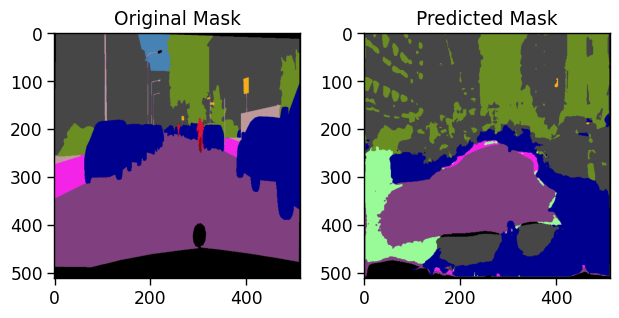

800/800 [==============================] - 371s 394ms/step - loss: 1.0808 - accuracy: 0.6663 - mean_iou: 0.2331 - val_loss: 2.0471 - val_accuracy: 0.4132 - val_mean_iou: 0.0966
Epoch 2/100
1/1 [==============================] - 0s 16ms/step- loss: 0.8642 - accuracy: 0.7375 - mean_iou: 0.29


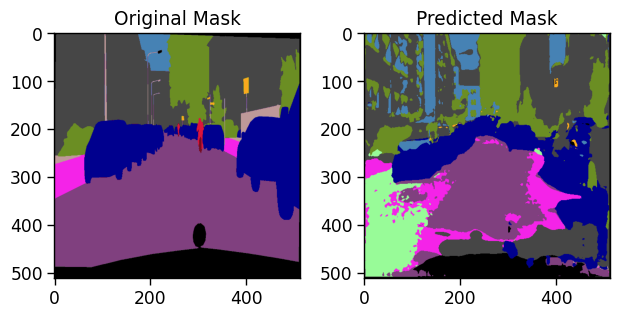

800/800 [==============================] - 301s 376ms/step - loss: 0.8642 - accuracy: 0.7375 - mean_iou: 0.2927 - val_loss: 1.3324 - val_accuracy: 0.5850 - val_mean_iou: 0.1715
Epoch 3/100
1/1 [==============================] - 0s 16ms/step- loss: 0.7861 - accuracy: 0.7640 - mean_iou: 0.31


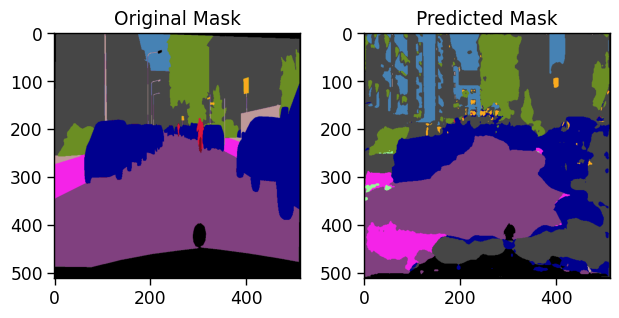

800/800 [==============================] - 305s 382ms/step - loss: 0.7861 - accuracy: 0.7640 - mean_iou: 0.3153 - val_loss: 1.5835 - val_accuracy: 0.5657 - val_mean_iou: 0.1763
Epoch 4/100
1/1 [==============================] - 0s 16ms/step- loss: 0.7202 - accuracy: 0.7870 - mean_iou: 0.33


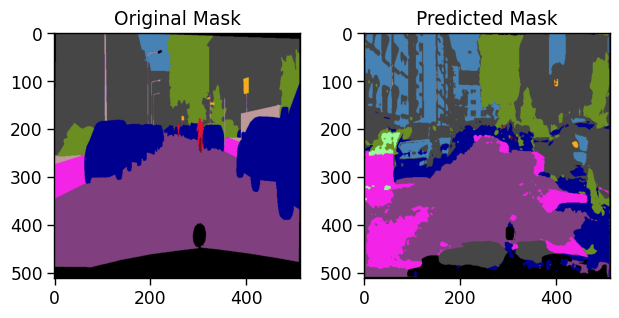

800/800 [==============================] - 305s 382ms/step - loss: 0.7202 - accuracy: 0.7870 - mean_iou: 0.3391 - val_loss: 1.1343 - val_accuracy: 0.6448 - val_mean_iou: 0.1998
Epoch 5/100
1/1 [==============================] - 0s 15ms/step- loss: 0.6716 - accuracy: 0.8028 - mean_iou: 0.35


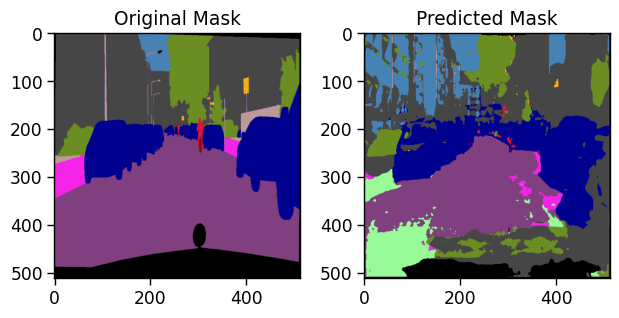

800/800 [==============================] - 310s 387ms/step - loss: 0.6716 - accuracy: 0.8028 - mean_iou: 0.3575 - val_loss: 1.9054 - val_accuracy: 0.4956 - val_mean_iou: 0.1535
Epoch 6/100
1/1 [==============================] - 0s 15ms/step- loss: 0.6168 - accuracy: 0.8211 - mean_iou: 0.38


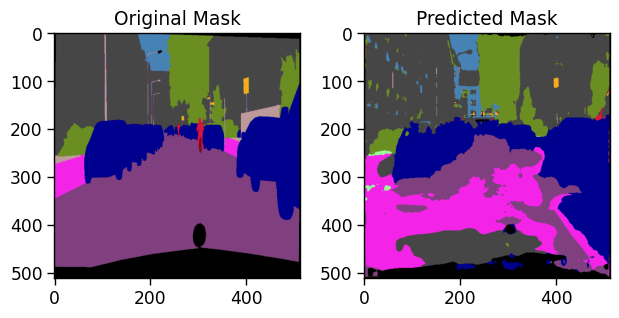

800/800 [==============================] - 305s 382ms/step - loss: 0.6168 - accuracy: 0.8211 - mean_iou: 0.3804 - val_loss: 0.8459 - val_accuracy: 0.7463 - val_mean_iou: 0.2818
Epoch 7/100
1/1 [==============================] - 0s 16ms/step- loss: 0.5855 - accuracy: 0.8298 - mean_iou: 0.39


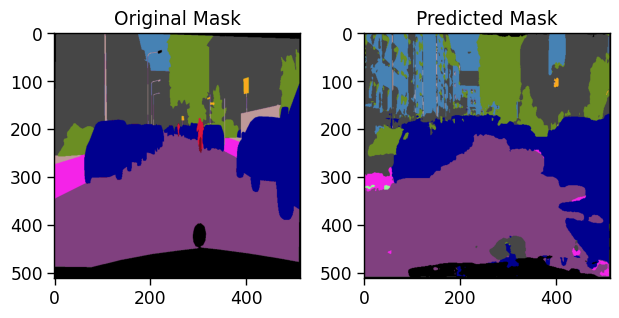

800/800 [==============================] - 303s 379ms/step - loss: 0.5855 - accuracy: 0.8298 - mean_iou: 0.3945 - val_loss: 0.8343 - val_accuracy: 0.7279 - val_mean_iou: 0.2311
Epoch 8/100
1/1 [==============================] - 0s 15ms/step- loss: 0.5589 - accuracy: 0.8365 - mean_iou: 0.40


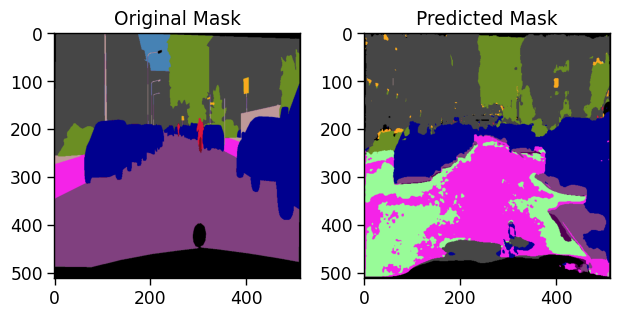

800/800 [==============================] - 305s 382ms/step - loss: 0.5589 - accuracy: 0.8365 - mean_iou: 0.4043 - val_loss: 1.0569 - val_accuracy: 0.6758 - val_mean_iou: 0.2266
Epoch 9/100
1/1 [==============================] - 0s 16ms/step- loss: 0.5360 - accuracy: 0.8450 - mean_iou: 0.41


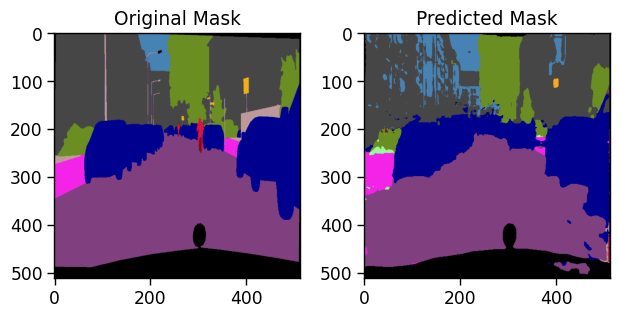

800/800 [==============================] - 305s 382ms/step - loss: 0.5360 - accuracy: 0.8450 - mean_iou: 0.4138 - val_loss: 0.6068 - val_accuracy: 0.8294 - val_mean_iou: 0.3239
Epoch 10/100
1/1 [==============================] - 0s 16ms/step- loss: 0.5066 - accuracy: 0.8527 - mean_iou: 0.42


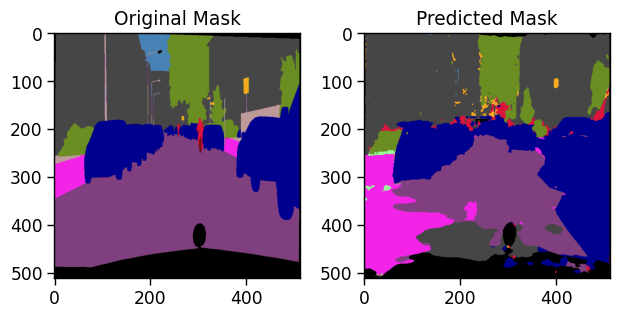

800/800 [==============================] - 303s 378ms/step - loss: 0.5066 - accuracy: 0.8527 - mean_iou: 0.4268 - val_loss: 0.9109 - val_accuracy: 0.7563 - val_mean_iou: 0.2673
Epoch 11/100
1/1 [==============================] - 0s 15ms/step- loss: 0.4902 - accuracy: 0.8564 - mean_iou: 0.43


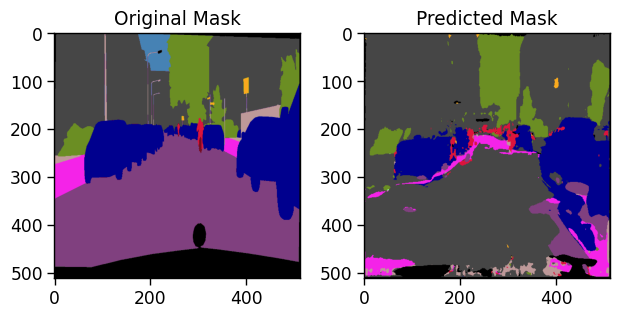

800/800 [==============================] - 305s 381ms/step - loss: 0.4902 - accuracy: 0.8564 - mean_iou: 0.4355 - val_loss: 0.9553 - val_accuracy: 0.7138 - val_mean_iou: 0.2551
Epoch 12/100
1/1 [==============================] - 0s 15ms/step- loss: 0.4777 - accuracy: 0.8596 - mean_iou: 0.44


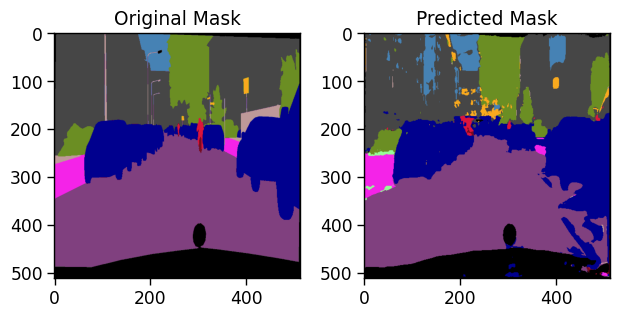

800/800 [==============================] - 308s 385ms/step - loss: 0.4777 - accuracy: 0.8596 - mean_iou: 0.4422 - val_loss: 0.8875 - val_accuracy: 0.7542 - val_mean_iou: 0.3112
Epoch 13/100
1/1 [==============================] - 0s 16ms/step- loss: 0.4648 - accuracy: 0.8631 - mean_iou: 0.44


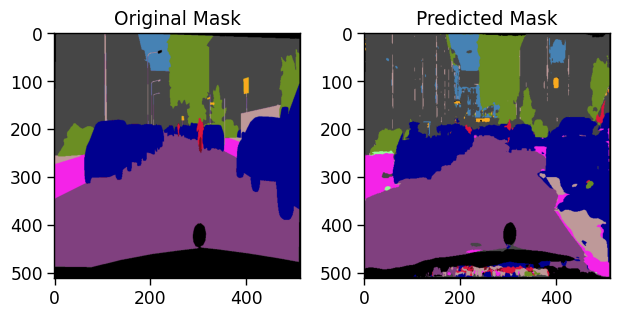

800/800 [==============================] - 312s 390ms/step - loss: 0.4648 - accuracy: 0.8631 - mean_iou: 0.4487 - val_loss: 0.7606 - val_accuracy: 0.7557 - val_mean_iou: 0.3039
Epoch 14/100
1/1 [==============================] - 0s 16ms/step- loss: 0.4380 - accuracy: 0.8705 - mean_iou: 0.46


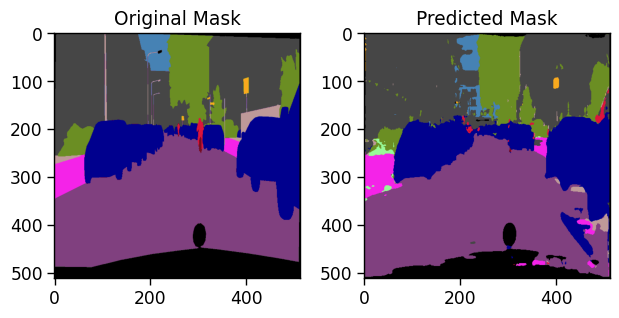

800/800 [==============================] - 300s 375ms/step - loss: 0.4380 - accuracy: 0.8705 - mean_iou: 0.4659 - val_loss: 0.5034 - val_accuracy: 0.8607 - val_mean_iou: 0.4105
Epoch 15/100
1/1 [==============================] - 0s 16ms/step- loss: 0.4356 - accuracy: 0.8710 - mean_iou: 0.46


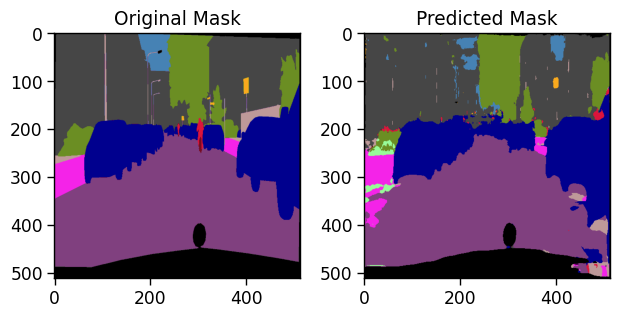

800/800 [==============================] - 308s 385ms/step - loss: 0.4356 - accuracy: 0.8710 - mean_iou: 0.4643 - val_loss: 0.6408 - val_accuracy: 0.8030 - val_mean_iou: 0.3497
Epoch 16/100
1/1 [==============================] - 0s 16ms/step- loss: 0.4162 - accuracy: 0.8762 - mean_iou: 0.47


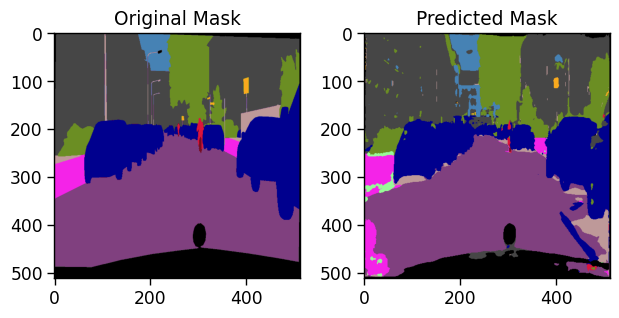

800/800 [==============================] - 308s 385ms/step - loss: 0.4162 - accuracy: 0.8762 - mean_iou: 0.4768 - val_loss: 0.6667 - val_accuracy: 0.8155 - val_mean_iou: 0.3380
Epoch 17/100
1/1 [==============================] - 0s 15ms/step- loss: 0.4070 - accuracy: 0.8779 - mean_iou: 0.48


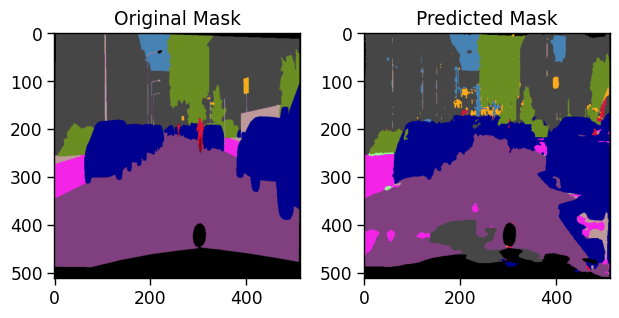

800/800 [==============================] - 307s 384ms/step - loss: 0.4070 - accuracy: 0.8779 - mean_iou: 0.4834 - val_loss: 0.6158 - val_accuracy: 0.8151 - val_mean_iou: 0.3357
Epoch 18/100
1/1 [==============================] - 0s 18ms/step- loss: 0.3860 - accuracy: 0.8843 - mean_iou: 0.49


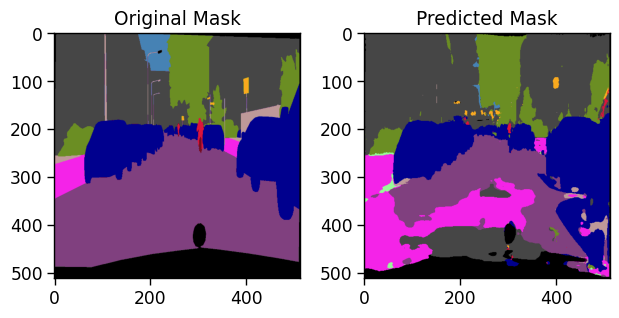

800/800 [==============================] - 305s 381ms/step - loss: 0.3860 - accuracy: 0.8843 - mean_iou: 0.4968 - val_loss: 0.4703 - val_accuracy: 0.8722 - val_mean_iou: 0.4109
Epoch 19/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3918 - accuracy: 0.8824 - mean_iou: 0.49


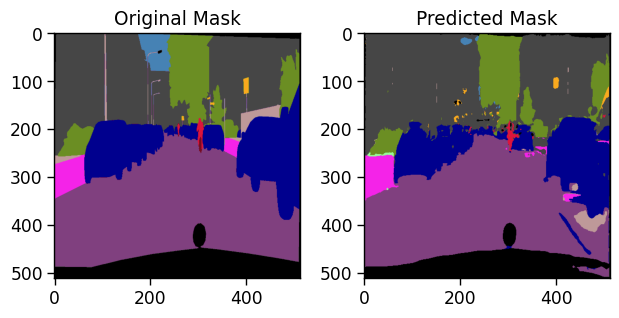

800/800 [==============================] - 302s 378ms/step - loss: 0.3918 - accuracy: 0.8824 - mean_iou: 0.4946 - val_loss: 0.5700 - val_accuracy: 0.8327 - val_mean_iou: 0.3861
Epoch 20/100
1/1 [==============================] - 0s 15ms/step- loss: 0.3729 - accuracy: 0.8873 - mean_iou: 0.51


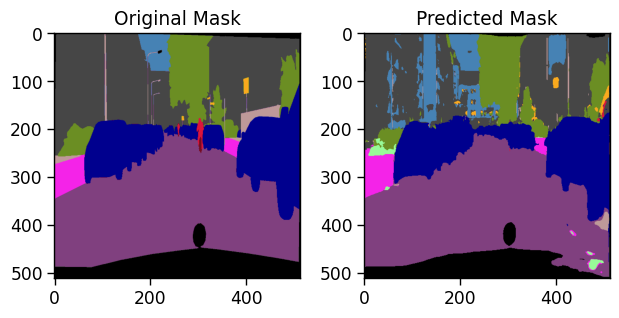

800/800 [==============================] - 307s 384ms/step - loss: 0.3729 - accuracy: 0.8873 - mean_iou: 0.5101 - val_loss: 0.5912 - val_accuracy: 0.8326 - val_mean_iou: 0.3445
Epoch 21/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3539 - accuracy: 0.8923 - mean_iou: 0.52


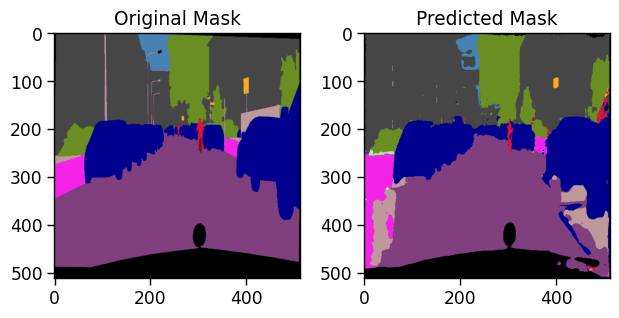

800/800 [==============================] - 302s 378ms/step - loss: 0.3539 - accuracy: 0.8923 - mean_iou: 0.5229 - val_loss: 0.5429 - val_accuracy: 0.8434 - val_mean_iou: 0.3835
Epoch 22/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3379 - accuracy: 0.8969 - mean_iou: 0.53


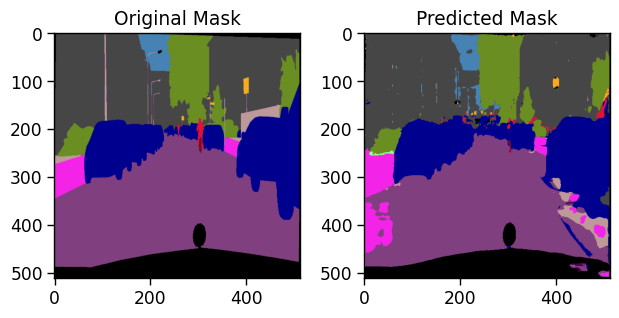

800/800 [==============================] - 302s 378ms/step - loss: 0.3379 - accuracy: 0.8969 - mean_iou: 0.5330 - val_loss: 0.5547 - val_accuracy: 0.8448 - val_mean_iou: 0.3632
Epoch 23/100
1/1 [==============================] - 0s 15ms/step- loss: 0.3387 - accuracy: 0.8961 - mean_iou: 0.53


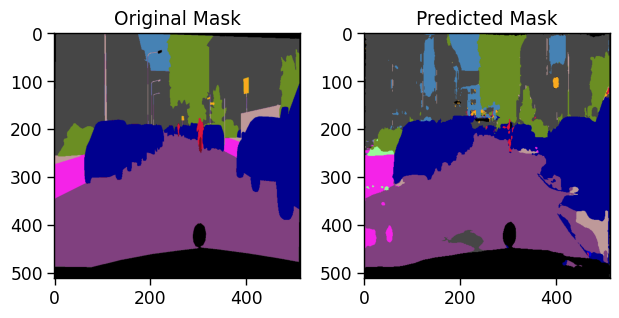

800/800 [==============================] - 300s 375ms/step - loss: 0.3387 - accuracy: 0.8961 - mean_iou: 0.5394 - val_loss: 0.7754 - val_accuracy: 0.8019 - val_mean_iou: 0.3657
Epoch 24/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3194 - accuracy: 0.9018 - mean_iou: 0.55


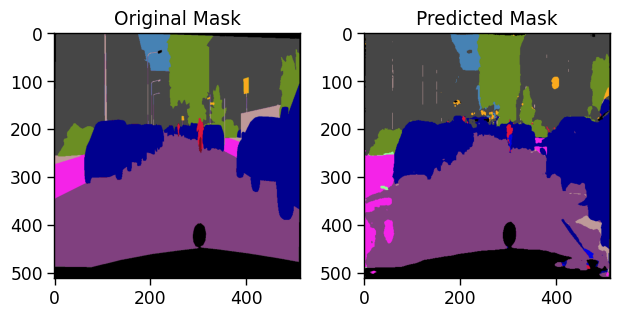

800/800 [==============================] - 309s 387ms/step - loss: 0.3194 - accuracy: 0.9018 - mean_iou: 0.5561 - val_loss: 0.4532 - val_accuracy: 0.8765 - val_mean_iou: 0.3924
Epoch 25/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3093 - accuracy: 0.9048 - mean_iou: 0.56


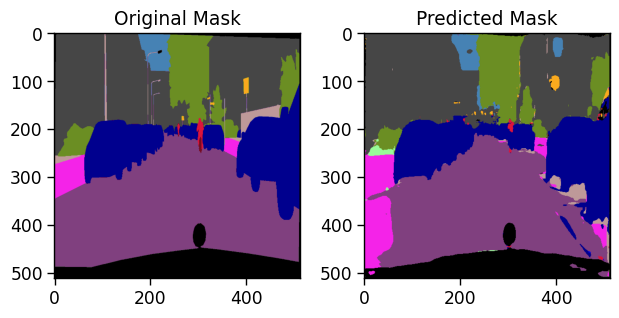

800/800 [==============================] - 315s 394ms/step - loss: 0.3093 - accuracy: 0.9048 - mean_iou: 0.5660 - val_loss: 0.3838 - val_accuracy: 0.8950 - val_mean_iou: 0.4230
Epoch 26/100
1/1 [==============================] - 0s 16ms/step- loss: 0.3096 - accuracy: 0.9047 - mean_iou: 0.56


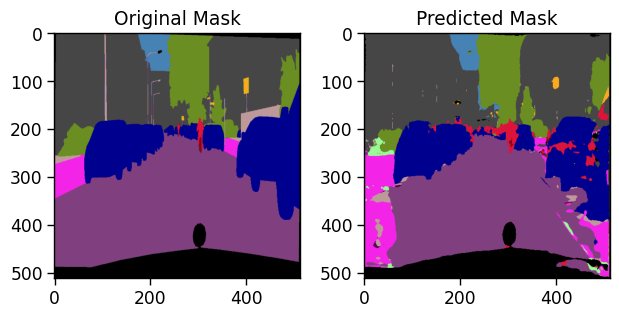

800/800 [==============================] - 308s 386ms/step - loss: 0.3096 - accuracy: 0.9047 - mean_iou: 0.5673 - val_loss: 0.5426 - val_accuracy: 0.8331 - val_mean_iou: 0.3765
Epoch 27/100
1/1 [==============================] - 0s 15ms/step- loss: 0.2852 - accuracy: 0.9115 - mean_iou: 0.58


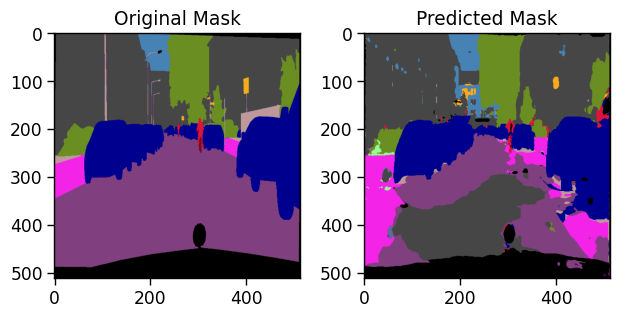

800/800 [==============================] - 313s 391ms/step - loss: 0.2852 - accuracy: 0.9115 - mean_iou: 0.5846 - val_loss: 0.6585 - val_accuracy: 0.8160 - val_mean_iou: 0.3691
Epoch 28/100
1/1 [==============================] - 0s 15ms/step- loss: 0.2709 - accuracy: 0.9158 - mean_iou: 0.60


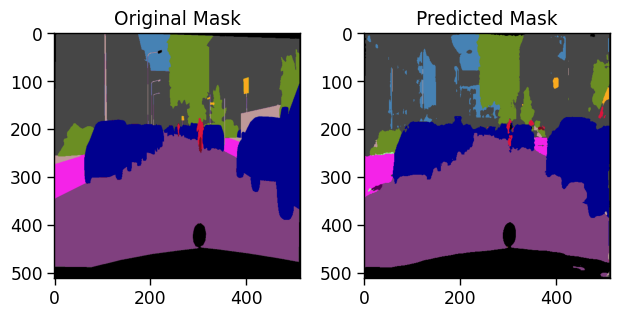

800/800 [==============================] - 310s 387ms/step - loss: 0.2709 - accuracy: 0.9158 - mean_iou: 0.6016 - val_loss: 0.5046 - val_accuracy: 0.8630 - val_mean_iou: 0.4027
Epoch 29/100
1/1 [==============================] - 0s 16ms/step- loss: 0.2661 - accuracy: 0.9169 - mean_iou: 0.61


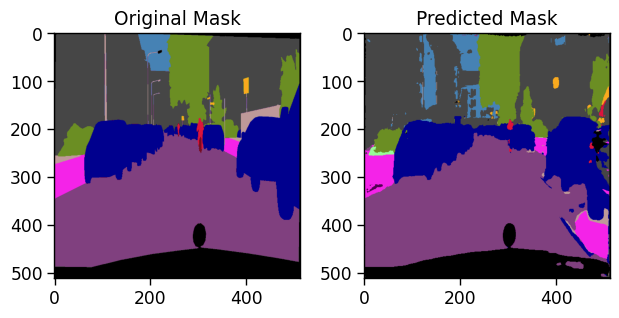

800/800 [==============================] - 309s 387ms/step - loss: 0.2661 - accuracy: 0.9169 - mean_iou: 0.6107 - val_loss: 0.4575 - val_accuracy: 0.8693 - val_mean_iou: 0.4348
Epoch 30/100
1/1 [==============================] - 0s 17ms/step- loss: 0.2541 - accuracy: 0.9211 - mean_iou: 0.62


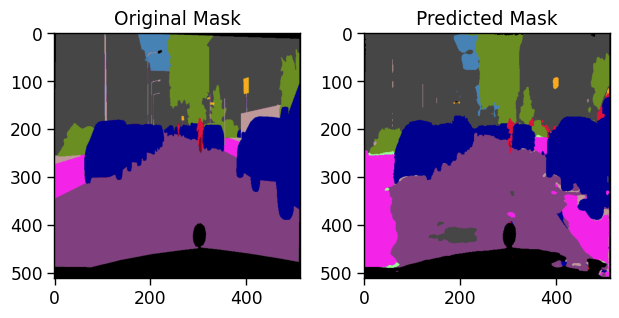

800/800 [==============================] - 307s 384ms/step - loss: 0.2541 - accuracy: 0.9211 - mean_iou: 0.6251 - val_loss: 0.6312 - val_accuracy: 0.8379 - val_mean_iou: 0.3980
Epoch 31/100
1/1 [==============================] - 0s 15ms/step- loss: 0.2467 - accuracy: 0.9231 - mean_iou: 0.63


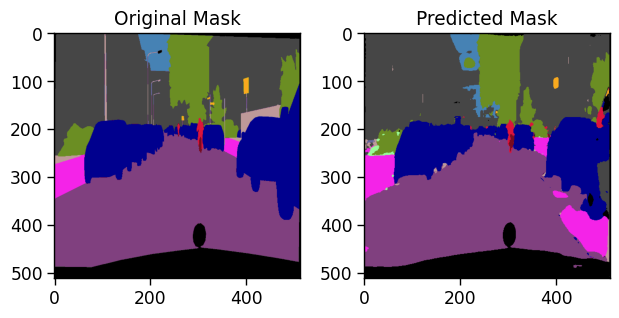

800/800 [==============================] - 305s 381ms/step - loss: 0.2467 - accuracy: 0.9231 - mean_iou: 0.6359 - val_loss: 0.3945 - val_accuracy: 0.8836 - val_mean_iou: 0.4498
Epoch 32/100
1/1 [==============================] - 0s 12ms/step- loss: 0.3368 - accuracy: 0.8992 - mean_iou: 0.56


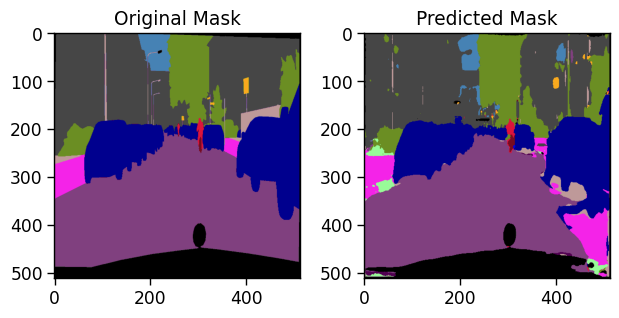

800/800 [==============================] - 300s 374ms/step - loss: 0.3368 - accuracy: 0.8992 - mean_iou: 0.5645 - val_loss: 0.4967 - val_accuracy: 0.8555 - val_mean_iou: 0.3785
Epoch 33/100
1/1 [==============================] - 0s 22ms/step- loss: 0.2507 - accuracy: 0.9218 - mean_iou: 0.63


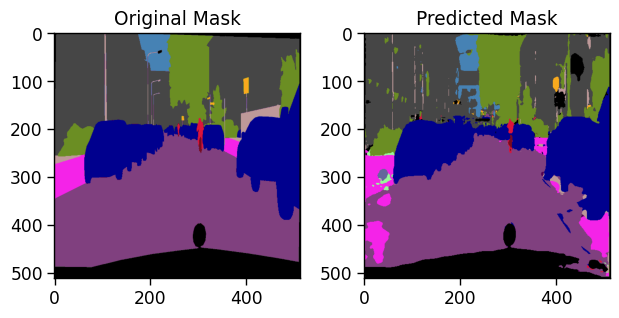

800/800 [==============================] - 303s 378ms/step - loss: 0.2507 - accuracy: 0.9218 - mean_iou: 0.6307 - val_loss: 0.5458 - val_accuracy: 0.8436 - val_mean_iou: 0.4054
Epoch 34/100
1/1 [==============================] - 0s 15ms/step- loss: 0.2170 - accuracy: 0.9320 - mean_iou: 0.67


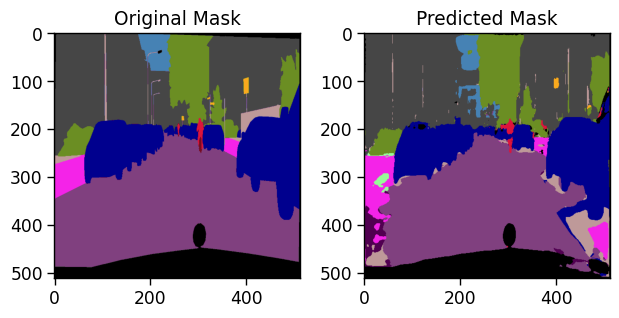

800/800 [==============================] - 305s 381ms/step - loss: 0.2170 - accuracy: 0.9320 - mean_iou: 0.6708 - val_loss: 0.5418 - val_accuracy: 0.8456 - val_mean_iou: 0.4248
Epoch 35/100
1/1 [==============================] - 0s 18ms/step- loss: 0.2084 - accuracy: 0.9349 - mean_iou: 0.68


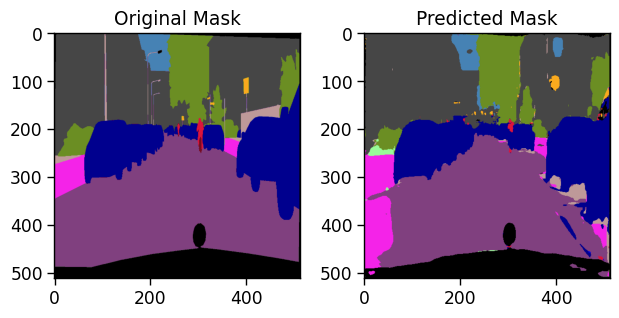

800/800 [==============================] - 306s 383ms/step - loss: 0.2084 - accuracy: 0.9349 - mean_iou: 0.6870 - val_loss: 0.5861 - val_accuracy: 0.8408 - val_mean_iou: 0.3777


In [18]:
history = model.fit(x=X_train[:800], y=Y_train[:800], epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid[:1], Y_valid[:1]), callbacks=[early_stopping,viz_callback])

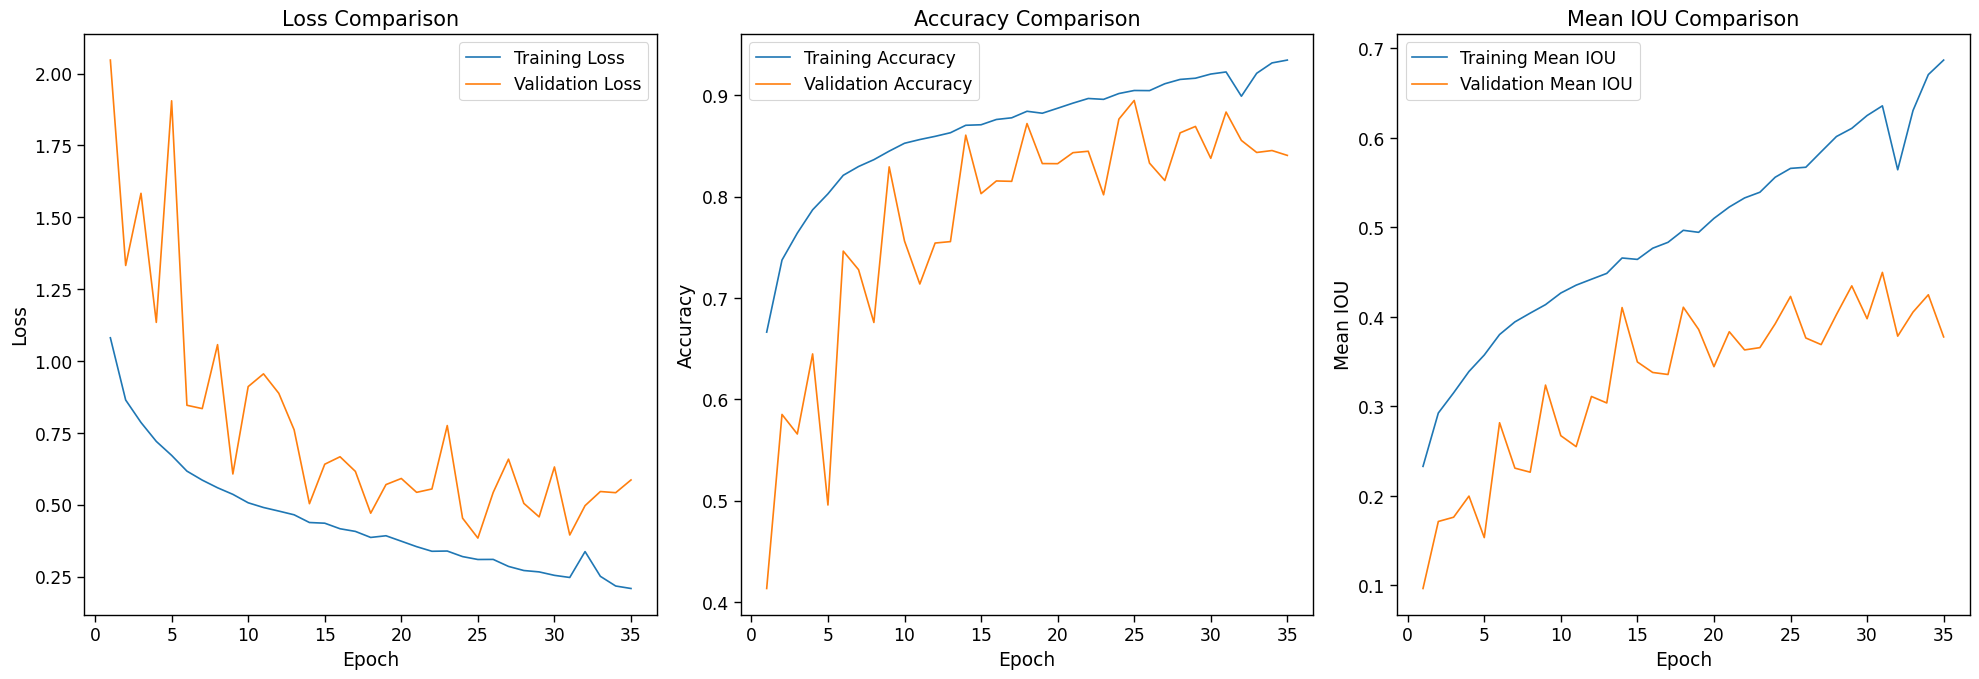

In [20]:
plot_history(history)

9 Saving Model

In [22]:
model.save("model_hd_RC_Final.h5")

10 Loading Trained Model

In [16]:
def load_model():
    # Define the custom objects without ignore_class
    custom_objects = {'UpdatedMeanIoU': UpdatedMeanIoU(num_classes=num_classes)}
    model = tf.keras.models.load_model('model_hd_RC_Final.h5', custom_objects=custom_objects)
    return model

In [17]:
model=load_model()

1/1 [==============================] - 11s 11s/step


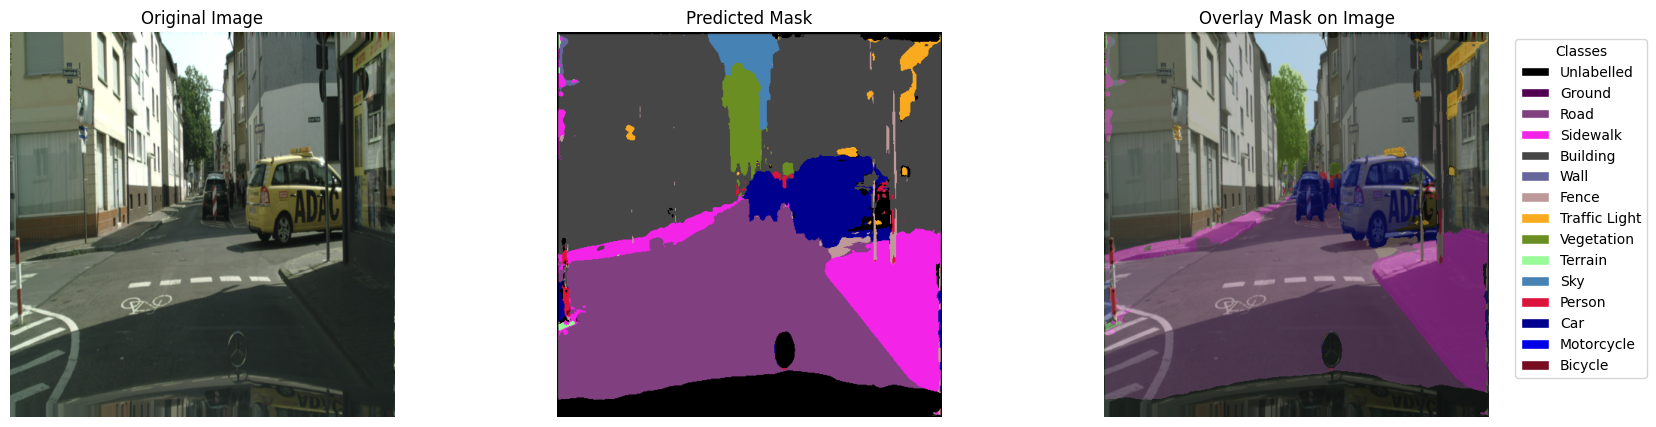

1/1 [==============================] - 0s 25ms/step


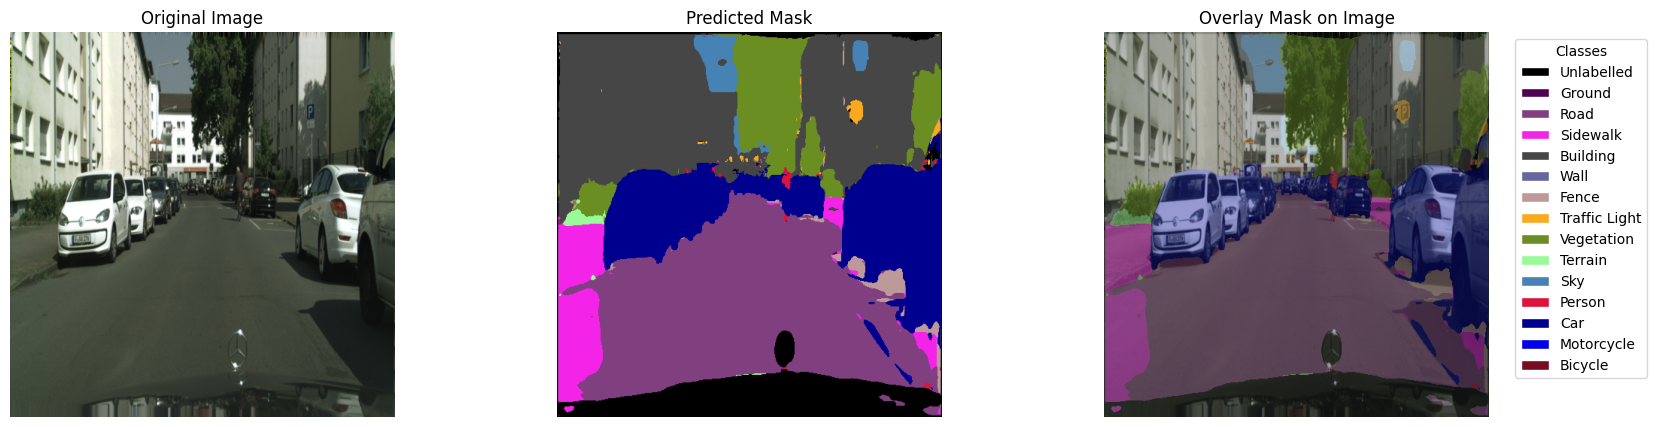

1/1 [==============================] - 0s 12ms/step


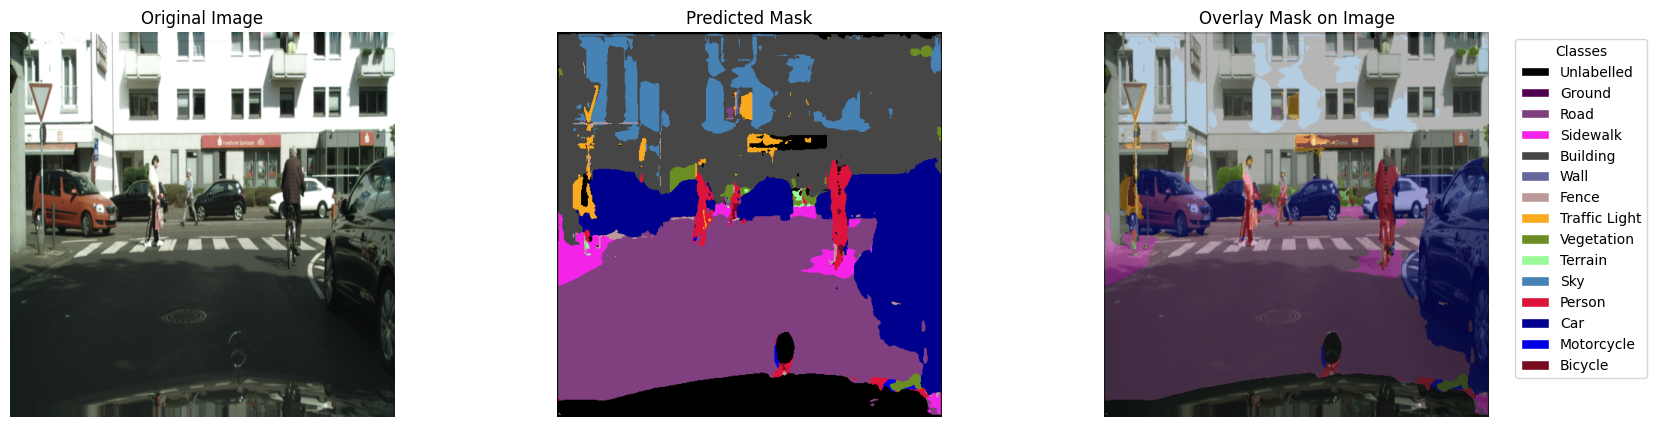

In [18]:
mask_plot(X_valid,3,model)

11 Video Output by Model

In [19]:
x=video_prepare_tensor_dataset("D:/demoVideo/leftImg8bit/demoVideo/stuttgart_01")

100%|██████████| 1100/1100 [01:09<00:00, 15.72it/s]


In [21]:
video_writer = imageio.get_writer('output_video_Masked_01.mp4', fps=24)
for i in range(len(x)):
    img = x[i]
    img = np.reshape(img, (512, 512, 3))  # Reshape for prediction
    pred = model.predict(np.expand_dims(img, axis=0))  # Predict mask
    y_pred = tf.math.argmax(pred, axis=-1).numpy().reshape(512, 512)
    
    y_pred_rgb = label_to_color(y_pred, id_map)  # Convert mask to RGB

    # Overlay mask on the original image
    overlay_img = overlay_mask_on_image(img, y_pred_rgb, alpha=0.4)

    # Append the frame to the video
    video_writer.append_data(overlay_img)

# Finalize the video file
video_writer.close()

1/1 [==============================] - 0s 16ms/step
